In [1]:
import copy
# import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

import matplotlib.pyplot as plt
import math
import queue
import heapq

import ClusterEnsembles as CE

import warnings
warnings.filterwarnings('ignore')

In [2]:
my_random_seed = 23
np.random.seed(my_random_seed)

In [19]:
list_of_num_clusters = np.array([3, 7, 15, 25]) # 
list_of_probability_out = np.array([10, 20, 30, 40, 50, 60, 70])
# list_of_kolvo = np.array([10, 25, 50, 75, 100])
list_of_kolvo = np.array([2, 3, 4, 5, 6, 7, 8, 9])
tests = list(range(1, 51))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange']

In [4]:
def load_test(num_cl, prob, test):
    if test not in tests:
        return [], [], []
    file_name = '/Users/ilnurbaykov/HomeWork/diplom/tests/' + f'clusters{num_cl}/' + f'prob0_{prob}/' + f'test_{test}.txt'
    f = open(file_name, 'r')
    clusters = int(f.readline())
    correct_dict = {}
    correct = [0] * 1000
    for cl in range(clusters):
        line = list(map(int, f.readline().split()))
        for el in line:
            correct_dict[el] = cl
            correct[el - 1] = cl
#     print(clusters)
#     print(correct)
    prob = float(f.readline())
    num_viborka = int(f.readline())
#     print(prob)
#     print(num_viborka)
    vVib_dict = []
    for vb in range(num_viborka):
        viborka_dict = {}
        for cl in range(clusters):
            line = list(map(int, f.readline().split()))
            for el in line:
                viborka_dict[el] = cl
        vVib_dict.append(viborka_dict)
    return np.array(correct), np.array(correct_dict), np.array(vVib_dict)

In [5]:
def load_test_mcla(num_cl, prob, test):
    if test not in tests:
        return [], [], []
    file_name = '/Users/ilnurbaykov/HomeWork/diplom/tests/' + f'clusters{num_cl}/' + f'prob0_{prob}/' + f'test_{test}.txt'
    f = open(file_name, 'r')
    clusters = int(f.readline())
    correct = [0] * 1000
    for cl in range(clusters):
        line = list(map(int, f.readline().split()))
        for el in line:
            correct[el - 1] = cl
#     print(clusters)
#     print(correct)
    prob = float(f.readline())
    num_viborka = int(f.readline())
#     print(prob)
#     print(num_viborka)
    vVib = []
    for vb in range(num_viborka):
        viborka = [0] * 1000
        for cl in range(clusters):
            line = list(map(int, f.readline().split()))
            for el in line:
                viborka[el - 1] = cl
        vVib.append(viborka)
    return np.array(correct), np.array(vVib)

In [6]:
def print_list_of_list(v):
    for raw in v:
        for el in raw:
            print(str(el), end = ' ')
        print()
    return

In [7]:
def add_to_consensus_matrix(viborka_dict, consensus_matrix):
    for i in range(1000):
        for j in range(1000):
            if (viborka_dict[i + 1] == viborka_dict[j + 1]):
                consensus_matrix[i][j] += 1

In [8]:
def get_consensus_matrix(vVib_dict, kolvo, need_del = 1):
    consensus_matrix = np.zeros((1000, 1000))
    for i in range(kolvo):
        add_to_consensus_matrix(vVib_dict[i], consensus_matrix)
    if need_del:
        consensus_matrix /= kolvo
    return consensus_matrix

In [9]:
def get_mcla_matrix(vVib, kolvo):
    answer = vVib[:kolvo]
    return np.array(answer)

In [10]:
def add_to_kmeans_matrix(viborka_dict, idi, num_cl, consensus_matrix):
    for i in range(1000):
        idj = idi * num_cl + viborka_dict[i + 1]
        consensus_matrix[i][idj] = 1.0

In [11]:
def get_kmeans_matrix(vVib_dict, kolvo, num_cl):
    consensus_matrix = np.zeros((1000, kolvo * num_cl))
    for i in range(kolvo):
        add_to_kmeans_matrix(vVib_dict[i], i, num_cl, consensus_matrix)
    return consensus_matrix

In [12]:
def show_picture(consensus_matrix):
    corr = np.corrcoef(consensus_matrix.T)

    fig, ax = plt.subplots(1, 1)
    coll = ax.imshow(corr, vmin=-1, vmax=1, cmap='viridis')
    ax.set(xticklabels=[], yticklabels=[])
    fig.colorbar(coll)

In [13]:
def get_distance_matrix(consensus_matrix):
    exper_con_mat = copy.deepcopy(consensus_matrix)
    exper_con_mat = 1 - exper_con_mat
    np.fill_diagonal(exper_con_mat, 0)
    return exper_con_mat

In [14]:
def get_distance_matrix_log(consensus_matrix):
    exper_con_mat = copy.deepcopy(consensus_matrix)
    exper_con_mat = - np.log(exper_con_mat)
    np.fill_diagonal(exper_con_mat, 0)
    exper_con_mat[np.isinf(exper_con_mat)] = 10
    return exper_con_mat

In [15]:
def get_R(cons_matrix):
    answer = np.zeros((len(cons_matrix[0]), len(cons_matrix[0])))
    my_sum = np.sum(cons_matrix) #* cons_matrix[0][0]
    sum_col1 = np.sum(cons_matrix, axis=0)
    sum_col2 = np.sum(cons_matrix, axis=0)
    sum_col1 = sum_col1.reshape(1, len(sum_col1))
    sum_col2 = sum_col2.reshape(len(sum_col2), 1)
    answer = sum_col1 * sum_col2
    answer /= my_sum
    return answer

In [16]:
def save_results_to_file(results, num_cl, is_ari, algo_name, is_two):
    name = '/Users/ilnurbaykov/HomeWork/diplom' + f'/answers/' + f'clusters{num_cl}/{algo_name}'
    if is_ari:
        name += '/ari'
    else:
        name += '/ami'
    if is_two:
        name += '_2_9'
    name += '.txt'
    f = open(name, 'w+')
    for row in results:
        for j in row:
            f.write(str(j) + ' ')
        f.write('\n')
    f.close()
    return

In [17]:
def draw_kolvo_ari(kolvo_ari, num_cl, algo_name, is_two):
    save_results_to_file(kolvo_ari, num_cl, 1, algo_name, is_two)
    fig, ax = plt.subplots(figsize=(10, 5))
    yrs = np.array([0, 10, 20, 30, 40, 50, 60, 70])
    for i in range(len(kolvo_ari)):
        ax.plot(yrs, kolvo_ari[i], color = colors[i], label = f'ARI, {list_of_kolvo[i]} consensus')
    ax.set_title(f'ARI, {num_cl} clusters.')
    ax.legend(loc='upper left')
    ax.set_ylabel('Total debt')
    ax.set_xlabel('Delete probality')
    ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
    ax.legend()
    ax.grid()
    fig.tight_layout()

    plt.show()

In [18]:
def draw_kolvo_ami(kolvo_ami, num_cl, algo_name, is_two):
    save_results_to_file(kolvo_ami, num_cl, 0, algo_name, is_two)
    fig, ax = plt.subplots(figsize=(10, 5))
    yrs = np.array([0, 10, 20, 30, 40, 50, 60, 70])
    for i in range(len(kolvo_ami)):
        ax.plot(yrs, kolvo_ami[i], color = colors[i], label = f'AMI, {list_of_kolvo[i]} consensus')
    ax.set_title(f'AMI, {num_cl} clusters.')
    ax.legend(loc='upper left')
    ax.set_ylabel('Total debt')
    ax.set_xlabel('Delete probality')
    ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
    ax.legend()
    ax.grid()
    fig.tight_layout()

    plt.show()

## CSPA

..........3 2
..........3 3
..........3 4
..........3 5
..........3 6
..........3 7
..........3 8
..........3 9


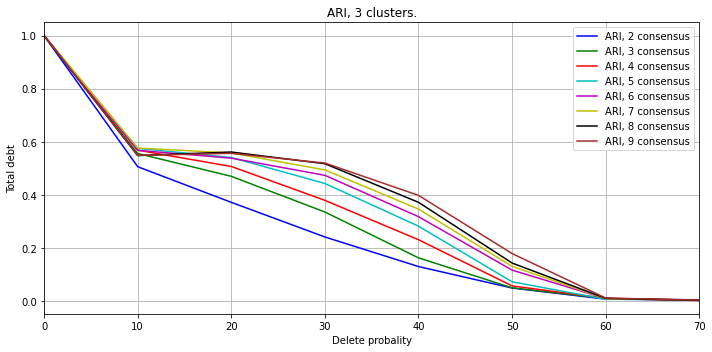

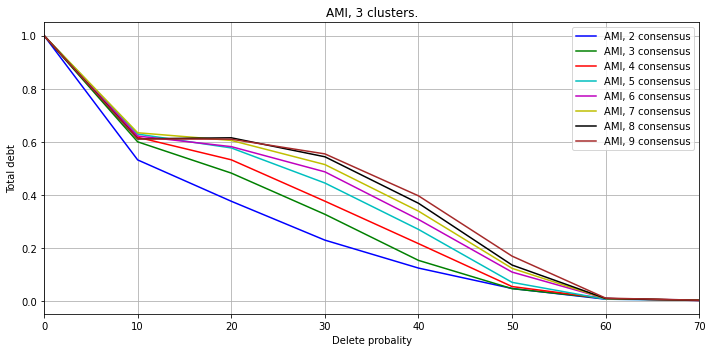

..........7 2
..........7 3
.

KeyboardInterrupt: 

In [30]:
test_st = 1
test_end = 11


for num_cl in list_of_num_clusters:
    kolvo_ari = []
    kolvo_ami = []
    for kolvo in list_of_kolvo:
        mid_ari = np.zeros(len(list_of_probability_out) + 1)
        mid_ami = np.zeros(len(list_of_probability_out) + 1)
        for test in range(test_st, test_end):
            aries = [1]
            amies = [1]
            for prob in list_of_probability_out:
                correct, vVib = load_test_mcla(num_cl, prob, test)
                data = get_mcla_matrix(vVib, kolvo)

                model = CE.cluster_ensembles(data, solver='cspa', random_state=my_random_seed)
    #             print(model)
    #             print(np.array(correct))
                ari = sklearn.metrics.adjusted_rand_score(correct, model)
                ami = sklearn.metrics.adjusted_mutual_info_score(correct, model)
#                 print(num_cl, prob, ari, ami)
                aries.append(ari)
                amies.append(ami)
            aries = np.array(aries)
            amies = np.array(amies)
            mid_ari += aries
            mid_ami += amies
            print('.', end='')
        print(num_cl, kolvo)
        mid_ami /= (test_end - test_st)
        mid_ari /= (test_end - test_st)
#         draw(mid_ari, mid_ami, num_cl, kolvo)
        kolvo_ari.append(mid_ari)
        kolvo_ami.append(mid_ami)
    draw_kolvo_ari(kolvo_ari, num_cl, 'cspa', 1)
    draw_kolvo_ami(kolvo_ami, num_cl, 'cspa', 1)

In [36]:
correct, vVib = load_test_mcla(3, 30, 4)
data = get_mcla_matrix(vVib, 100)
model = CE.cluster_ensembles(data, solver='hbgf', random_state=my_random_seed)

ari = sklearn.metrics.adjusted_rand_score(correct, model)
print(len(data))
print(ari)
print(correct)
print(model)

100
0.36294063700686463
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 